#### solving the parity problem using RNN

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import theano
import theano.tensor as T 
import numpy as np
import matplotlib.pyplot as plt 

##### RNN

In [29]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from util import init_weight, all_parity_pairs_with_sequence_labels


class SimpleRNN:
    def __init__(self, M):
        self.M = M # hidden layer size

    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=100, show_fig=False):
        D = X[0].shape[1] # X is of size N x T(n) x D
        K = len(set(Y.flatten()))
        N = len(Y)
        M = self.M
        self.f = activation

        # initial weights
        Wx = init_weight(D, M)
        Wh = init_weight(M, M)
        bh = np.zeros(M)
        h0 = np.zeros(M)
        Wo = init_weight(M, K)
        bo = np.zeros(K)

        # make them theano shared
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]

        thX = T.fmatrix('X')
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1):
            h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        [h, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, None],
            sequences=thX,
            n_steps=thX.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction, y],
            updates=updates
        )

        costs = []
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            for j in xrange(N):
                c, p, rout = self.train_op(X[j], Y[j])
                cost += c
                if p[-1] == Y[j,-1]:
                    n_correct += 1
            print "i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N)
            costs.append(cost)
            if n_correct == N:
                break

        if show_fig:
            plt.plot(costs)
            plt.show()


def parity(B=12, learning_rate=10e-5, epochs=200):
    X, Y = all_parity_pairs_with_sequence_labels(B)

    rnn = SimpleRNN(4)
    rnn.fit(X, Y, learning_rate=learning_rate, epochs=epochs, activation=T.tanh, show_fig=True)  
    return rnn

i: 0 cost: 2829.85521365 classification rate: 0.499268292683
i: 1 cost: 2824.08234642 classification rate: 0.499512195122
i: 2 cost: 2807.0819149 classification rate: 0.501463414634
i: 3 cost: 2704.27443548 classification rate: 0.499756097561
i: 4 cost: 2486.09050401 classification rate: 0.50487804878
i: 5 cost: 2389.73036241 classification rate: 0.504634146341
i: 6 cost: 2329.2951929 classification rate: 0.502682926829
i: 7 cost: 2261.31500294 classification rate: 0.497317073171
i: 8 cost: 2196.34388926 classification rate: 0.5
i: 9 cost: 2163.9086855 classification rate: 0.502926829268
i: 10 cost: 2148.56855581 classification rate: 0.501707317073
i: 11 cost: 2140.48522751 classification rate: 0.501707317073
i: 12 cost: 2134.58090799 classification rate: 0.503414634146
i: 13 cost: 2131.71618167 classification rate: 0.504146341463
i: 14 cost: 2128.84487528 classification rate: 0.503414634146
i: 15 cost: 2126.57516589 classification rate: 0.503414634146
i: 16 cost: 2124.93462779 classif

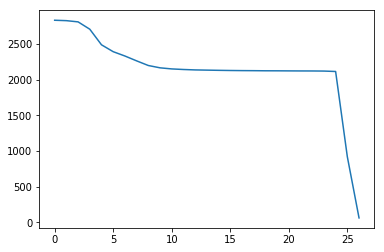

In [30]:
rnn = parity()

In [31]:
rnn.predict_op(np.array([1, 0, 1, 0, 1], dtype=np.float32).reshape(-1, 1))

array([1, 1, 0, 0, 1])

##### GRU

In [42]:
class GRU:
    def __init__(self, M):
        self.M = M # hidden layer size

    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=100, show_fig=False):
        D = X[0].shape[1] 
        K = len(set(Y.flatten()))
        N = len(Y)
        M = self.M
        self.f = activation

        Wxr = init_weight(D, M)
        Whr = init_weight(M, M)
        br  = np.zeros(M)
        Wxz = init_weight(D, M)
        Whz = init_weight(M, M)
        bz  = np.zeros(M)
        Wxh = init_weight(D, M)
        Whh = init_weight(M, M)
        bh  = np.zeros(M)
        h0  = np.zeros(M)
        Wo = init_weight(M, K)
        bo = np.zeros(K)

        # theano vars
        self.Wxr = theano.shared(Wxr)
        self.Whr = theano.shared(Whr)
        self.br  = theano.shared(br)
        self.Wxz = theano.shared(Wxz)
        self.Whz = theano.shared(Whz)
        self.bz  = theano.shared(bz)
        self.Wxh = theano.shared(Wxh)
        self.Whh = theano.shared(Whh)
        self.bh  = theano.shared(bh)
        self.h0  = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wxr, self.Whr, self.br, self.Wxz, self.Whz, self.bz, self.Wxh, self.Whh, self.bh, 
                       self.h0, self.Wo, self.bo]

        thX = T.fmatrix('X')
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1):
            r_t = T.nnet.nnet.sigmoid(x_t.dot(self.Wxr) + h_t1.dot(self.Whr) + self.br)
            z_t = T.nnet.nnet.sigmoid(x_t.dot(self.Wxz) + h_t1.dot(self.Whz) + self.bz)
            hhat_t = self.f(x_t.dot(self.Wxh) + (r_t * h_t1).dot(self.Whh) + self.bh)
            h_t = ( 1 - z_t) * h_t1 + z_t * hhat_t
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        [h, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, None],
            sequences=thX,
            n_steps=thX.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction, y],
            updates=updates
        )

        costs = []
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            for j in xrange(N):
                c, p, rout = self.train_op(X[j], Y[j])
                cost += c
                if p[-1] == Y[j,-1]:
                    n_correct += 1
            print "i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N)
            costs.append(cost)
            if n_correct == N:
                break

        if show_fig:
            plt.plot(costs)
            plt.show()


def parity_gru(B=12, learning_rate=10e-5, epochs=200):
    X, Y = all_parity_pairs_with_sequence_labels(B)

    gru = GRU(4)
    gru.fit(X, Y, learning_rate=learning_rate, epochs=epochs, activation=T.tanh, show_fig=True)  
    return gru

i: 0 cost: 2838.82693421 classification rate: 0.494390243902
i: 1 cost: 2829.40506202 classification rate: 0.500487804878
i: 2 cost: 2823.16730698 classification rate: 0.501463414634
i: 3 cost: 2813.97392561 classification rate: 0.502926829268
i: 4 cost: 2793.02280711 classification rate: 0.499268292683
i: 5 cost: 2738.52835083 classification rate: 0.497804878049
i: 6 cost: 2629.55853745 classification rate: 0.504146341463
i: 7 cost: 1984.42380188 classification rate: 0.614146341463
i: 8 cost: 112.742301358 classification rate: 0.999024390244
i: 9 cost: 35.1580380061 classification rate: 1.0


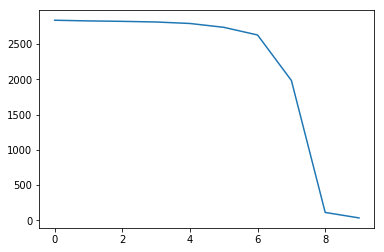

In [44]:
gru = parity_gru()

In [45]:
gru.predict_op(np.array([1, 0, 1, 0, 1], dtype=np.float32).reshape(-1, 1))

array([1, 1, 0, 0, 1])

##### LSTM

In [51]:
class LSTM:
    def __init__(self, M):
        self.M = M # hidden layer size

    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=100, show_fig=False):
        D = X[0].shape[1] 
        K = len(set(Y.flatten()))
        N = len(Y)
        M = self.M
        self.f = activation

        # weights for i_t
        Wxi = init_weight(D, M)
        Whi = init_weight(M, M)
        Wci = init_weight(M, M)
        bi  = np.zeros(M)
        
        # weights for f_t 
        Wxf = init_weight(D, M)
        Whf = init_weight(M, M)
        Wcf = init_weight(M, M)
        bf = np.zeros(M)
        
        # weights for c_t
        Wxc = init_weight(D, M)
        Whc = init_weight(M, M)
        bc = np.zeros(M)
        
        # weights for o_t 
        Wxo = init_weight(D, M)
        Who = init_weight(M, M)
        Wco = init_weight(M, M)
        bo = np.zeros(M)
        
        # Initial values 
        c0 = np.zeros(M)
        h0 = np.zeros(M)
        
        Woo = init_weight(M, K)
        boo = np.zeros(K)
        
        # weights for i_t
        self.Wxi = theano.shared(Wxi)
        self.Whi = theano.shared(Whi)
        self.Wci = theano.shared(Wci)
        self.bi = theano.shared(bi)
        
        # weights for f_t
        self.Wxf = theano.shared(Wxf)
        self.Whf = theano.shared(Whf)
        self.Wcf = theano.shared(Wcf)
        self.bf = theano.shared(bf)
        
        # weights for c_t 
        self.Wxc = theano.shared(Wxc)
        self.Whc = theano.shared(Whc)
        self.bc = theano.shared(bc)
        
        # weights for o_t
        self.Wxo = theano.shared(Wxo)
        self.Who = theano.shared(Who)
        self.Wco = theano.shared(Wco)
        self.bo = theano.shared(bo)
        
        # Initial weights 
        self.c0 = theano.shared(c0)
        self.h0 = theano.shared(h0)
        
        self.Woo = theano.shared(Woo)
        self.boo = theano.shared(boo)
        
        self.params = [self.Wxi, self.Whi, self.Wci, self.bi, \
                       self.Wxf, self.Whf, self.Wcf, self.bf, \
                       self.Wxc, self.Whc, self.bc, \
                       self.Wxo, self.Who, self.Wco, self.bo, \
                       self.c0, self.h0, self.Woo, self.boo]
        
        thX = T.fmatrix('X')
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1, c_t1):
            i_t = T.nnet.sigmoid(x_t.dot(self.Wxi) + h_t1.dot(self.Whi) + c_t1.dot(self.Wci) + self.bi)
            f_t = T.nnet.sigmoid(x_t.dot(self.Wxf) + h_t1.dot(self.Whf) + c_t1.dot(self.Wcf) + self.bf)
            c_t = f_t * c_t1 + i_t * T.tanh(x_t.dot(self.Wxc) + h_t1.dot(self.Whc) + self.bc)
            o_t = T.nnet.sigmoid(x_t.dot(self.Wxo) + h_t1.dot(self.Who) + c_t.dot(self.Wco) + self.bo)
            h_t = o_t * T.tanh(c_t)
            y_t = T.nnet.softmax(h_t.dot(self.Woo) + self.boo)
            return h_t, c_t, y_t
    
        
        [h, c, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, self.c0, None],
            sequences=thX,
            n_steps=thX.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction, y],
            updates=updates
        )

        costs = []
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            for j in xrange(N):
                c, p, rout = self.train_op(X[j], Y[j])
                cost += c
                if p[-1] == Y[j,-1]:
                    n_correct += 1
            print "i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N)
            costs.append(cost)
            if n_correct == N:
                break

        if show_fig:
            plt.plot(costs)
            plt.show()


def parity_lstm(B=12, learning_rate=10e-5, epochs=200):
    X, Y = all_parity_pairs_with_sequence_labels(B)

    lstm = LSTM(4)
    lstm.fit(X, Y, learning_rate=learning_rate, epochs=epochs, activation=T.tanh, show_fig=True)  
    return lstm

i: 0 cost: 2846.20684849 classification rate: 0.508048780488
i: 1 cost: 2839.93866702 classification rate: 0.490975609756
i: 2 cost: 2833.70456889 classification rate: 0.49512195122
i: 3 cost: 2826.48753154 classification rate: 0.498292682927
i: 4 cost: 2814.91195755 classification rate: 0.503170731707
i: 5 cost: 2795.00510416 classification rate: 0.498780487805
i: 6 cost: 2749.02066143 classification rate: 0.499024390244
i: 7 cost: 2640.5532041 classification rate: 0.5
i: 8 cost: 2511.1313085 classification rate: 0.494146341463
i: 9 cost: 2433.50354199 classification rate: 0.495853658537
i: 10 cost: 2378.09531217 classification rate: 0.506829268293
i: 11 cost: 2303.49945155 classification rate: 0.5
i: 12 cost: 2161.94503824 classification rate: 0.497804878049
i: 13 cost: 1149.92452173 classification rate: 0.738536585366
i: 14 cost: 129.421600924 classification rate: 1.0


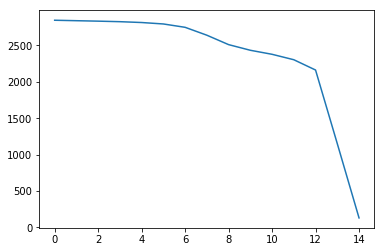

In [52]:
lstm = parity_lstm()

In [53]:
lstm.predict_op(np.array([1, 0, 1, 0, 1], dtype=np.float32).reshape(-1, 1))

array([1, 1, 0, 0, 1])